## Demo of Temperature diffusion (PoissonEq) in an annulus
### Check against an simple analytic solution and plot radial temperature

In [1]:
import underworld as uw
import glucifer
import numpy as np
import underworld.function as fn

In [2]:
## Parameters

# radius of the bottom and top
rb = 3.
rt = 6.

# surface temperature at the bottom and top
tb = 10.
tt = 5.

# analytic solution assuming diffusivity is 1 and 0 heating, 
# ie. T_ii = 0, T(rb) = tb, T(rt) = tt 
fac = (tt-tb) / np.log(rt/rb)
def np_analytic(r):
    return np.log( (r)/rb) * fac  + tb

In [3]:
annulus = uw.mesh.FeMesh_Annulus(elementRes=(20,100), radialLengths=(rb,rt), angularExtent=(0.0,360.0))
tField  = annulus.add_variable(nodeDofCount=1)

# analytic function description, only possible one we have the fn_radial
fn_r = annulus.fn_radial
fn_analytic = fn.math.log( fn_r/rb ) * fac  + tb

In [4]:
fig = glucifer.Figure()
fig.append(glucifer.objects.Mesh(annulus))
fig.append(glucifer.objects.Surface(annulus, tField, onMesh=True))
# fig.show()

In [5]:
outer = annulus.specialSets["outer"]
inner = annulus.specialSets["inner"]

tField.data[inner.data] = tb
tField.data[outer.data] = tt

In [6]:
tBC      = uw.conditions.DirichletCondition( variable=tField, indexSetsPerDof=(inner+outer))
ssSLE    = uw.systems.SteadyStateHeat(tField,fn_diffusivity=1.0, conditions=tBC)
ssSolver = uw.systems.Solver(ssSLE)

ssSolver.solve()

In [7]:
# error measurement - l2 norm
fn_e = fn.math.pow(fn_analytic - tField, 2.)

error = annulus.integrate(fn_e)[0]
tolerance = 3.6e-4
if error > tolerance:
    es = "Model error greater the test tolerance. {:.4e} > {:.4e}".format(error, tolerance)
    raise RuntimeError(es)

In [8]:
# fig.show()

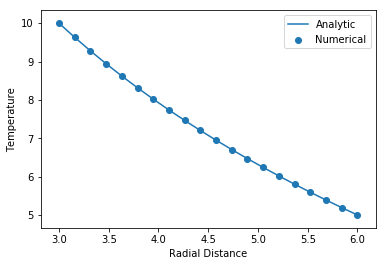

In [9]:
# if serial plot the 
if uw.mpi.size == 1:
    uw.matplotlib_inline()
    import matplotlib.pyplot as plt
    plt.ion()
    
    # Build a (Swarm) line of points along a constant angle
    p_x = np.ndarray((20,annulus.dim))
    theta = 0.
    p_x[:,0] = np.linspace(rb, rt, 20) # first build radial position
    p_x[:,1] = np.sin(theta)*p_x[:,0] 
    p_x[:,0] = np.cos(theta)*p_x[:,0]
    
    # Build a swarm
    swarm = uw.swarm.Swarm(annulus)
    swarm.add_particles_with_coordinates(p_x)
    
    # evaluate numerical and analytic fields
    measure_temp  = tField.evaluate(swarm)
    analytic_temp = np_analytic(p_x[:,0])

    ## Plot radial temperature and check against an analytic solution
    plt.plot(p_x[:,0],analytic_temp,label="Analytic")
    plt.scatter(p_x[:,0],measure_temp[:,0],label="Numerical")
    plt.xlabel("Radial Distance")
    plt.ylabel("Temperature")
    plt.legend()